# The Economics of Film
#### By Ariana Rozsnyoi, Caitlin Apcar, Mikhail Pavlov and Zachary Ash

# Introduction

Since the invention of the camera and moving pictures, film has been the main way for the world to experience media. However, with almost every household now owning a television set and the rise in streaming services such as Netflix, it can be argued that the popularity of going to the cinema to see a film is decreasing. Even with this change in the way we consume media, there are still films that hit the billion dollar box office mark - a definite hallmark of a film's success. <br>
<br>
What else determines a film's success? Do the director, actors and production companies play a part in how a film will perform at the box office? Can we predict the success of a film based on this?

# Datasets

We used 2 datasets in this analysis:
* [IMDB dataset](https://data.world/popculture/imdb-5000-movie-dataset)
    * This dataset contains 28 variables for 5043 movies, spanning across 100 years in 66 countries. 
* [Movie Revenue dataset](https://zenodo.org/record/1240586#.Xb-Vqi1L21v) 
    * This dataset contains 14 variables for 212385 movies up until 2017.

## Import statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

%matplotlib inline
import warnings
warnings.simplefilter('ignore')
from wordcloud import WordCloud

## Creating a usable Dataframe

With our data coming from two seperate sources, it was ideal to merge them into a single data set as they both contained the same films but had varying columns.

In [2]:
#First Dataset 

movie_data = pd.read_csv("data/movie_metadata.csv")

In [3]:
movie_data.shape

(5043, 28)

In [4]:
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [5]:
#Second Dataset 
movies = pd.read_csv("data/movies.csv")

In [6]:
movies.shape

(212385, 14)

In [7]:
movies.head()

,id,budget,genres,imdb_id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,title,vote_average,vote_count
0,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,1.698,Miramax Films,United States of America,25-12-95,4300000,Four Rooms,6.5,485
1,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,1.32287,Universal Pictures,Japan,15-10-93,12136938,Judgment Night,6.5,69
2,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),0.054716,inLoops,Austria,01-01-06,0,Life in Loops (A Megacities RMX),6.4,4
3,11,11000000,Adventure|Action|Science Fiction,tt0076759,en,Star Wars,10.492614,Lucasfilm,United States of America,25-05-77,775398007,Star Wars,8.0,6168
4,12,94000000,Animation|Family,tt0266543,en,Finding Nemo,9.915573,Pixar Animation Studios,United States of America,30-05-03,940335536,Finding Nemo,7.6,5531


In [8]:
movies.columns.tolist 

<bound method IndexOpsMixin.tolist of Index(['id', 'budget', 'genres', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'title',
       'vote_average', 'vote_count'],
      dtype='object')>

To easily join the data frames we first need to extract the `IMDB ID` from the movie link url in the first data frame.

In [9]:
print(movie_data['movie_imdb_link'][2])
test = movie_data['movie_imdb_link'][2].split('/')
test[-2]

http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1


'tt2379713'

In [10]:
len(movie_data['movie_imdb_link'])

5043

In [11]:
#get length of the col
total_len = len(movie_data['movie_imdb_link'])
values = []
for i in range(total_len):
    value = movie_data['movie_imdb_link'][i].split('/')[-2]
    values.append(value)#split the string to obtain id
movie_data['imdb_id'] = values #add the values in a new column

In [12]:
#check that ID matches
movie_data[['imdb_id','movie_imdb_link']].head()

,imdb_id,movie_imdb_link
0,tt0499549,http://www.imdb.com/title/tt0499549/?ref_=fn_t...
1,tt0449088,http://www.imdb.com/title/tt0449088/?ref_=fn_t...
2,tt2379713,http://www.imdb.com/title/tt2379713/?ref_=fn_t...
3,tt1345836,http://www.imdb.com/title/tt1345836/?ref_=fn_t...
4,tt5289954,http://www.imdb.com/title/tt5289954/?ref_=fn_t...


In [13]:
#example
for index, row in movie_data.iterrows():
    if row['imdb_id'] == 'tt0499549':
        print(row['movie_title'])

Avatar 


Now that we have the `IMDB ID` in both datasets, we can combine them into a single dataframe.

In [14]:
new_df = pd.merge(movies,movie_data,on='imdb_id')

In [15]:
new_df.shape

(4594, 42)

In [16]:
new_df.columns

Index(['id', 'budget_x', 'genres_x', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'title',
       'vote_average', 'vote_count', 'color', 'director_name',
       'num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'genres_y', 'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'budget_y', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')

In [17]:
new_df.head()

,id,budget_x,genres_x,imdb_id,original_language,original_title,popularity,production_companies,production_countries,release_date,...,num_user_for_reviews,language,country,content_rating,budget_y,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,1.698,Miramax Films,United States of America,25-12-95,...,177.0,English,USA,R,4000000.0,1995.0,975.0,6.7,1.85,0
1,11,11000000,Adventure|Action|Science Fiction,tt0076759,en,Star Wars,10.492614,Lucasfilm,United States of America,25-05-77,...,1470.0,English,USA,PG,11000000.0,1977.0,1000.0,8.7,2.35,33000
2,12,94000000,Animation|Family,tt0266543,en,Finding Nemo,9.915573,Pixar Animation Studios,United States of America,30-05-03,...,866.0,English,USA,G,94000000.0,2003.0,939.0,8.2,1.85,11000
3,13,55000000,Comedy|Drama|Romance,tt0109830,en,Forrest Gump,10.351236,Paramount Pictures,United States of America,06-07-94,...,1398.0,English,USA,PG-13,55000000.0,1994.0,294.0,8.8,2.35,59000
4,14,15000000,Drama,tt0169547,en,American Beauty,8.191009,DreamWorks SKG,United States of America,15-09-99,...,2715.0,English,USA,R,15000000.0,1999.0,828.0,8.4,2.35,22000


# Dropping Irrelevant Columns

There are a number of columns in our merged dataframe that are duplicate or will not provide anything of use in our analysis so they will be dropped.

In [18]:
new_df= new_df.drop(['id', 'title','original_language', 'popularity', 'vote_count', 'color', 'num_critic_for_reviews', 'duration', 
                     'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link', 
                     'num_user_for_reviews', 'content_rating', 'aspect_ratio', 'original_title'], axis=1) 

In [19]:
new_df.columns

Index(['budget_x', 'genres_x', 'imdb_id', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'vote_average',
       'director_name', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres_y',
       'actor_1_name', 'movie_title', 'actor_3_name', 'language', 'country',
       'budget_y', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes'],
      dtype='object')

In [20]:
new_df.shape

(4594, 25)

In [21]:
new_df.head()

,budget_x,genres_x,imdb_id,production_companies,production_countries,release_date,revenue,vote_average,director_name,director_facebook_likes,...,actor_1_name,movie_title,actor_3_name,language,country,budget_y,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,4000000,Crime|Comedy,tt0113101,Miramax Films,United States of America,25-12-95,4300000,6.5,Allison Anders,99.0,...,Salma Hayek,Four Rooms,Lili Taylor,English,USA,4000000.0,1995.0,975.0,6.7,0
1,11000000,Adventure|Action|Science Fiction,tt0076759,Lucasfilm,United States of America,25-05-77,775398007,8.0,George Lucas,0.0,...,Harrison Ford,Star Wars: Episode IV - A New Hope,Kenny Baker,English,USA,11000000.0,1977.0,1000.0,8.7,33000
2,94000000,Animation|Family,tt0266543,Pixar Animation Studios,United States of America,30-05-03,940335536,7.6,Andrew Stanton,475.0,...,Alexander Gould,Finding Nemo,Brad Garrett,English,USA,94000000.0,2003.0,939.0,8.2,11000
3,55000000,Comedy|Drama|Romance,tt0109830,Paramount Pictures,United States of America,06-07-94,677945399,8.2,Robert Zemeckis,0.0,...,Tom Hanks,Forrest Gump,Sam Anderson,English,USA,55000000.0,1994.0,294.0,8.8,59000
4,15000000,Drama,tt0169547,DreamWorks SKG,United States of America,15-09-99,356296601,7.9,Sam Mendes,0.0,...,Kevin Spacey,American Beauty,Ara Celi,English,USA,15000000.0,1999.0,828.0,8.4,22000


## Reformating the Dataframe

In [22]:
#Reordering columns for easy reading
sequence = ['imdb_id', 'movie_title','title_year','budget_x', 'genres_x',  'production_companies',
       'production_countries', 'release_date', 'revenue', 
       'vote_average', 'director_name', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'genres_y', 'actor_1_name',  'actor_3_name',
       'language', 'country', 'budget_y', 
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes']
new_df = new_df.reindex(columns=sequence)

In [23]:
new_df.head()

,imdb_id,movie_title,title_year,budget_x,genres_x,production_companies,production_countries,release_date,revenue,vote_average,...,gross,genres_y,actor_1_name,actor_3_name,language,country,budget_y,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,tt0113101,Four Rooms,1995.0,4000000,Crime|Comedy,Miramax Films,United States of America,25-12-95,4300000,6.5,...,4301331.0,Comedy|Fantasy,Salma Hayek,Lili Taylor,English,USA,4000000.0,975.0,6.7,0
1,tt0076759,Star Wars: Episode IV - A New Hope,1977.0,11000000,Adventure|Action|Science Fiction,Lucasfilm,United States of America,25-05-77,775398007,8.0,...,460935665.0,Action|Adventure|Fantasy|Sci-Fi,Harrison Ford,Kenny Baker,English,USA,11000000.0,1000.0,8.7,33000
2,tt0266543,Finding Nemo,2003.0,94000000,Animation|Family,Pixar Animation Studios,United States of America,30-05-03,940335536,7.6,...,380838870.0,Adventure|Animation|Comedy|Family,Alexander Gould,Brad Garrett,English,USA,94000000.0,939.0,8.2,11000
3,tt0109830,Forrest Gump,1994.0,55000000,Comedy|Drama|Romance,Paramount Pictures,United States of America,06-07-94,677945399,8.2,...,329691196.0,Comedy|Drama,Tom Hanks,Sam Anderson,English,USA,55000000.0,294.0,8.8,59000
4,tt0169547,American Beauty,1999.0,15000000,Drama,DreamWorks SKG,United States of America,15-09-99,356296601,7.9,...,130058047.0,Drama,Kevin Spacey,Ara Celi,English,USA,15000000.0,828.0,8.4,22000


In [24]:
#Dropping any rows that had missing/NaN data in order for us to be able to change the data types
clean_df = new_df.dropna()

clean_df.shape

(3683, 25)

In [25]:
#Converting columns that had floating point data types to integers
clean_df.astype({'title_year': 'int32', 'budget_y': 'int32', 'gross': 'int32', 'director_facebook_likes': 'int32', 'actor_3_facebook_likes' : 'int32', 'actor_1_facebook_likes' : 'int32'}).dtypes

imdb_id                     object
movie_title                 object
title_year                   int32
budget_x                     int64
genres_x                    object
production_companies        object
production_countries        object
release_date                object
revenue                      int64
vote_average               float64
director_name               object
director_facebook_likes      int32
actor_3_facebook_likes       int32
actor_2_name                object
actor_1_facebook_likes       int32
gross                        int32
genres_y                    object
actor_1_name                object
actor_3_name                object
language                    object
country                     object
budget_y                     int32
actor_2_facebook_likes     float64
imdb_score                 float64
movie_facebook_likes         int64
dtype: object

In [26]:
clean_df['title_year'] = clean_df['title_year'].round(0).astype(int)

In [27]:
clean_df['title_year']=  clean_df['title_year'].astype(str)

In [28]:
clean_df['title_year'].head()

0    1995
1    1977
2    2003
3    1994
4    1999
Name: title_year, dtype: object

In [29]:
clean_df = clean_df.drop(['budget_y'], axis=1)

In [30]:
clean_df.head()

,imdb_id,movie_title,title_year,budget_x,genres_x,production_companies,production_countries,release_date,revenue,vote_average,...,actor_1_facebook_likes,gross,genres_y,actor_1_name,actor_3_name,language,country,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,tt0113101,Four Rooms,1995,4000000,Crime|Comedy,Miramax Films,United States of America,25-12-95,4300000,6.5,...,4000.0,4301331.0,Comedy|Fantasy,Salma Hayek,Lili Taylor,English,USA,975.0,6.7,0
1,tt0076759,Star Wars: Episode IV - A New Hope,1977,11000000,Adventure|Action|Science Fiction,Lucasfilm,United States of America,25-05-77,775398007,8.0,...,11000.0,460935665.0,Action|Adventure|Fantasy|Sci-Fi,Harrison Ford,Kenny Baker,English,USA,1000.0,8.7,33000
2,tt0266543,Finding Nemo,2003,94000000,Animation|Family,Pixar Animation Studios,United States of America,30-05-03,940335536,7.6,...,1000.0,380838870.0,Adventure|Animation|Comedy|Family,Alexander Gould,Brad Garrett,English,USA,939.0,8.2,11000
3,tt0109830,Forrest Gump,1994,55000000,Comedy|Drama|Romance,Paramount Pictures,United States of America,06-07-94,677945399,8.2,...,15000.0,329691196.0,Comedy|Drama,Tom Hanks,Sam Anderson,English,USA,294.0,8.8,59000
4,tt0169547,American Beauty,1999,15000000,Drama,DreamWorks SKG,United States of America,15-09-99,356296601,7.9,...,18000.0,130058047.0,Drama,Kevin Spacey,Ara Celi,English,USA,828.0,8.4,22000


In [31]:
# drop rows that do not have any budget information
clean_df = clean_df.drop(clean_df[clean_df.budget_x == 0].index)
clean_df.shape

(3197, 24)

## Exploring the Data

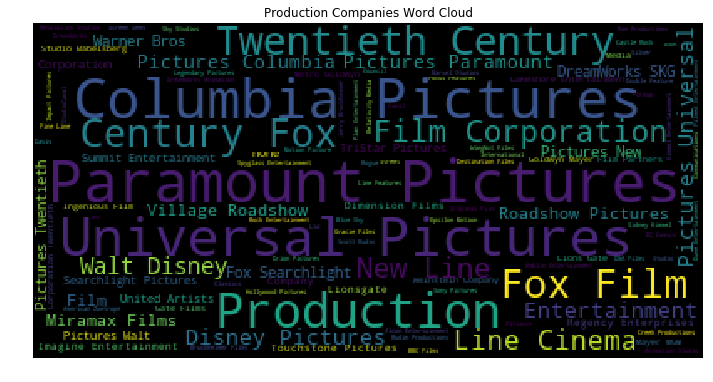

In [32]:
# Create a wordcloud to display most common Production Companies

wordcloud = WordCloud().generate(' '.join(clean_df['production_companies']))
plt.rcParams["figure.figsize"] = (12,12)
plt.title('Production Companies Word Cloud')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

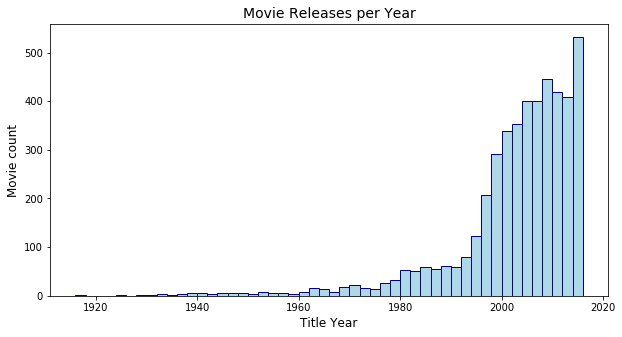

In [34]:
#Create graphic of number of films released each year
new_df.hist(column='title_year',bins=50, grid=False, color='lightblue',edgecolor='darkblue')
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel('Title Year', fontsize=12)
plt.ylabel('Movie count', fontsize=12)
plt.title('Movie Releases per Year', fontsize=14)
plt.show()

We can see that the number of movies produced started to increase after the 1990s and in the 2000s. This can be attributed to the age of digital media, with directors transitioning from using 38/70mm film to digital camera recordings which are cheaper and easier to edit (no need to physically cut film!). <br>
Also as disposable income and demand increased, directors and production companies needed to keep up and thus saturating the market with new movies. It can also be said that people nowadays are so used to binging content as a result of streaming services, that no one has the patience to wait for a movie's sequel - hence production companies churning them out so quickly in the last few years. 

In [35]:
#Creating a new dataframe to store average scores
average_score = clean_df[['title_year','imdb_score', 'production_countries']]
average_score.head()

,title_year,imdb_score,production_countries
0,1995,6.7,United States of America
1,1977,8.7,United States of America
2,2003,8.2,United States of America
3,1994,8.8,United States of America
4,1999,8.4,United States of America


In [36]:
average_score['title_year'] = pd.to_datetime(average_score['title_year'])
average_score.index = average_score['title_year']
average_score = average_score.drop(['title_year'], 1)
average_score.head()

,imdb_score,production_countries
title_year,,
1995-01-01,6.7,United States of America
1977-01-01,8.7,United States of America
2003-01-01,8.2,United States of America
1994-01-01,8.8,United States of America
1999-01-01,8.4,United States of America


In [37]:
usa = average_score[average_score['production_countries'].str.contains("United States of America")]
usa.head()

,imdb_score,production_countries
title_year,,
1995-01-01,6.7,United States of America
1977-01-01,8.7,United States of America
2003-01-01,8.2,United States of America
1994-01-01,8.8,United States of America
1999-01-01,8.4,United States of America


In [39]:
#Adapted from https://stackoverflow.com/questions/57577805/my-non-numeric-columns-are-deleted-on-resample
num = usa.select_dtypes('float64').columns
non_num = usa.columns.difference(num)
d = {**{x: 'mean' for x in num}, **{x: 'first' for x in non_num}}

#resample the data to get the mean imbd score for each year while keeping the non-numerical data
usa = usa.resample('AS').agg(d)
usa.head()

,imdb_score,production_countries
title_year,,
1929-01-01,6.3,United States of America
1930-01-01,NaN,NaN
1931-01-01,NaN,NaN
1932-01-01,NaN,NaN
1933-01-01,7.7,United States of America


In [40]:
usa = usa.dropna()

In [41]:
usa.head()

,imdb_score,production_countries
title_year,,
1929-01-01,6.3,United States of America
1933-01-01,7.7,United States of America
1935-01-01,7.8,United States of America
1936-01-01,8.6,United States of America
1937-01-01,7.7,United States of America


In [42]:
usa.index = pd.to_datetime(usa.index, format='%Y').year #format the index to just display year

In [43]:
usa_pivot = pd.pivot_table(usa, index=['production_countries'], columns=usa.index, values="imdb_score")

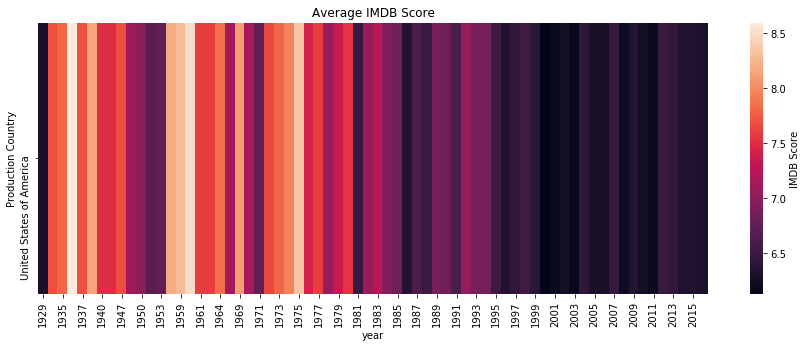

In [44]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)
sns.heatmap(usa_pivot,ax=ax, cbar_kws={'label': 'IMDB Score'})
ax.set_ylabel('Production Country')
ax.set_xlabel('year')
ax.set_title('Average IMDB Score')
plt.show()

The above heatplot displays that the average IMDB score for American produced movies has declined over the years.

In [119]:
corr = clean_df.corr()

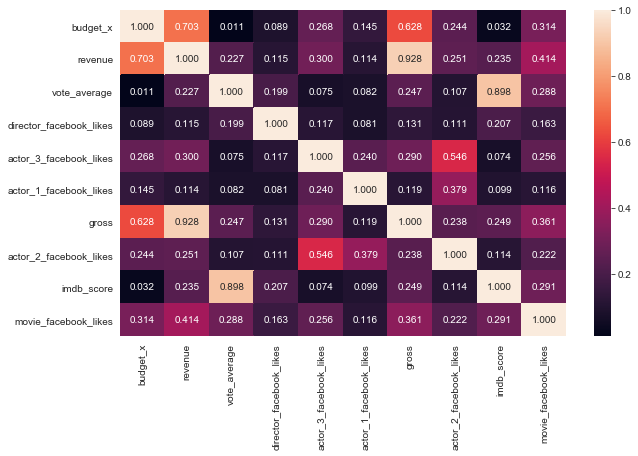

In [120]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
sns.heatmap(corr,ax=ax, annot=True, fmt=".3f")
plt.show()

Correlation between 10 variables

# Plot Highest Earning Movies

In [121]:
#sort revenue column in descending order + store it in a new dataframe.
top_10 = pd.DataFrame(clean_df['revenue'].sort_values(ascending = False))
top_10['movie_title'] = clean_df['movie_title']

top_10 = top_10.drop_duplicates()

#get top 10 movies with high revenue data from the dataframe.
top_10= top_10[['movie_title','revenue']][:10]

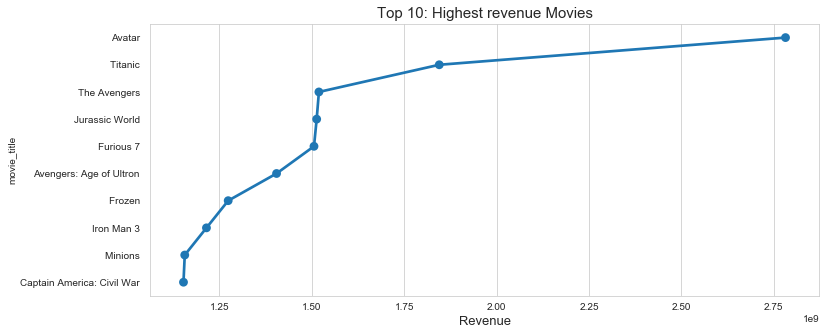

In [122]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
ax = sns.pointplot(x='revenue',y='movie_title', data=top_10)
ax.set_title("Top 10: Highest revenue Movies",fontsize = 15)
ax.set_xlabel("Revenue",fontsize = 13)
plt.show()

In [123]:
#sort revenue column in descending order + store it in a new dataframe for top production companies
top_10_prod = pd.DataFrame(clean_df['revenue'].sort_values(ascending = False))
top_10_prod['production_companies'] = clean_df['production_companies']
top_10_prod['production_countries'] = clean_df['production_countries']
top_10= top_10_prod[['production_companies','revenue', 'production_countries']][:20]

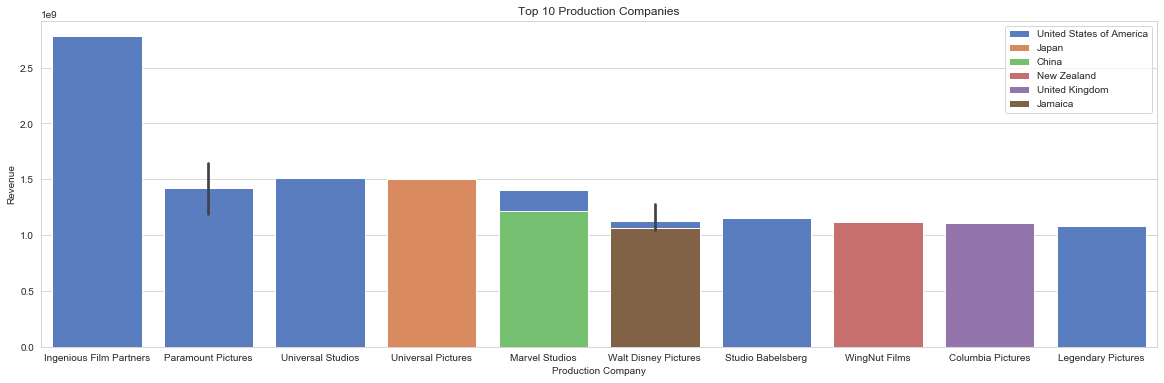

In [124]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(x="production_companies", y="revenue", hue='production_countries',data=top_10,dodge=False, palette='muted');
ax.set(xlabel='Production Company', ylabel='Revenue',title='Top 10 Production Companies')
plt.legend(loc='upper right')
plt.show()

As we can see there is a high saturation of American production companies with 6/10 being American. It should be noted that we dropped foreign language films which is likely to have had an impact on these results.  

# Plot Highest Earning Directors

In [125]:
# Using previously created top 10 revenue data, creating a new data frame to include the director
top_10[['movie_title', 'director_name']] = clean_df[['movie_title', 'director_name']]

top_10 = top_10.drop_duplicates()

#get top 10 movies with high revenue data from the dataframe.
top_10= top_10[['movie_title','revenue', 'director_name']][:10]

top_10.head()

,movie_title,revenue,director_name
2627,Avatar,2781505847,James Cameron
240,Titanic,1845034188,James Cameron
2783,The Avengers,1519557910,Joss Whedon
3944,Jurassic World,1513528810,Colin Trevorrow
4039,Furious 7,1506249360,James Wan


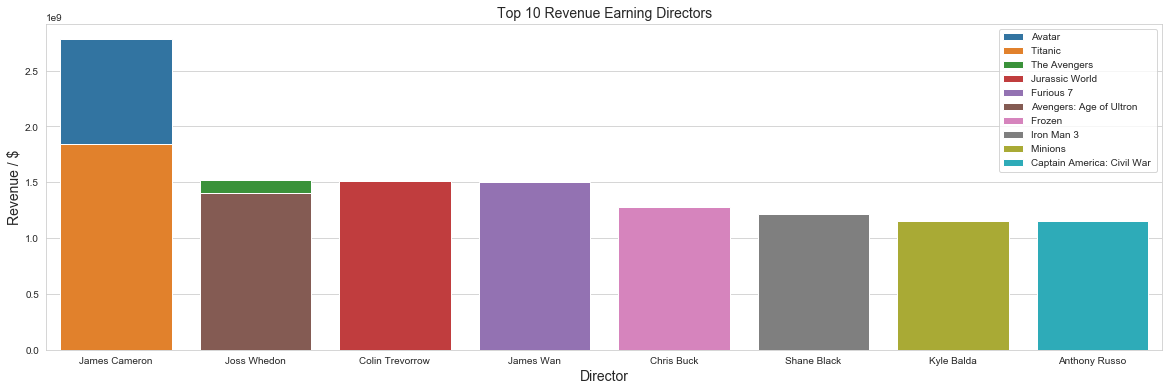

In [126]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(x="director_name", y="revenue", hue='movie_title',data=top_10,dodge=False);
plt.xlabel('Director', fontsize = 14)
plt.ylabel('Revenue / $', fontsize = 14)
plt.title('Top 10 Revenue Earning Directors', fontsize = 14)
plt.legend(loc='upper right')
plt.show()


# Splitting Genres

In our original dataframe, genres had been grouped together into a single column (`genres_x`). Obviously, films are classified into many genres and to have each genre apply to a seperate row would make for a messy (and enormous) dataframe. <br>

We created two datasets for different eploration and training purposes. The clean_dummy dataset which converts each genre to dummy values and then is joined back to the entire dataframe. Each genre has it's own column and if it applies to a film it is marked with a `1` in that row. <br>

The clean_string dataset includes the genres as object values. A new column 'genres' is added which includes the object vaule of the genre for exploration purposes.

In [31]:
#Creating a dummy dataframe for genres and joining it back into our original dataframe
clean_dummy = pd.DataFrame(clean_df).copy()

In [32]:
clean_dummy = clean_dummy.join(clean_dummy.pop('genres_x').str.get_dummies('|'))

In [33]:
clean_dummy.head()

,imdb_id,movie_title,title_year,budget_x,production_companies,production_countries,release_date,revenue,vote_average,director_name,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,tt0113101,Four Rooms,1995,4000000,Miramax Films,United States of America,25-12-95,4300000,6.5,Allison Anders,...,0,0,0,0,0,0,0,0,0,0
1,tt0076759,Star Wars: Episode IV - A New Hope,1977,11000000,Lucasfilm,United States of America,25-05-77,775398007,8.0,George Lucas,...,0,0,0,0,0,0,1,0,0,0
2,tt0266543,Finding Nemo,2003,94000000,Pixar Animation Studios,United States of America,30-05-03,940335536,7.6,Andrew Stanton,...,0,0,0,0,0,0,0,0,0,0
3,tt0109830,Forrest Gump,1994,55000000,Paramount Pictures,United States of America,06-07-94,677945399,8.2,Robert Zemeckis,...,0,0,0,0,0,1,0,0,0,0
4,tt0169547,American Beauty,1999,15000000,DreamWorks SKG,United States of America,15-09-99,356296601,7.9,Sam Mendes,...,0,0,0,0,0,0,0,0,0,0


# Exploring Genres


Code has been adapted from https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

In [34]:
#go through genres_x column and split on | to get the genre and apply to a series
clean = clean_df['genres_x'].str.split('|').apply(pd.Series, 1).stack()

In [35]:
clean.index = clean.index.droplevel(-1) #drop the multi-index
clean.name = 'genres' #add new column with the genre names
clean_string = clean_df.join(clean) #join back df

In [38]:
clean_string = clean_string.drop(['genres_x', 'genres_y'], 1)

In [39]:
genre = (pd.DataFrame(clean_string.groupby('genres').movie_title.nunique())).sort_values('movie_title', ascending=False)
genre

,movie_title
genres,
Drama,1658
Comedy,1372
Thriller,1003
Action,931
Romance,691
Adventure,668
Crime,563
Science Fiction,422
Family,420


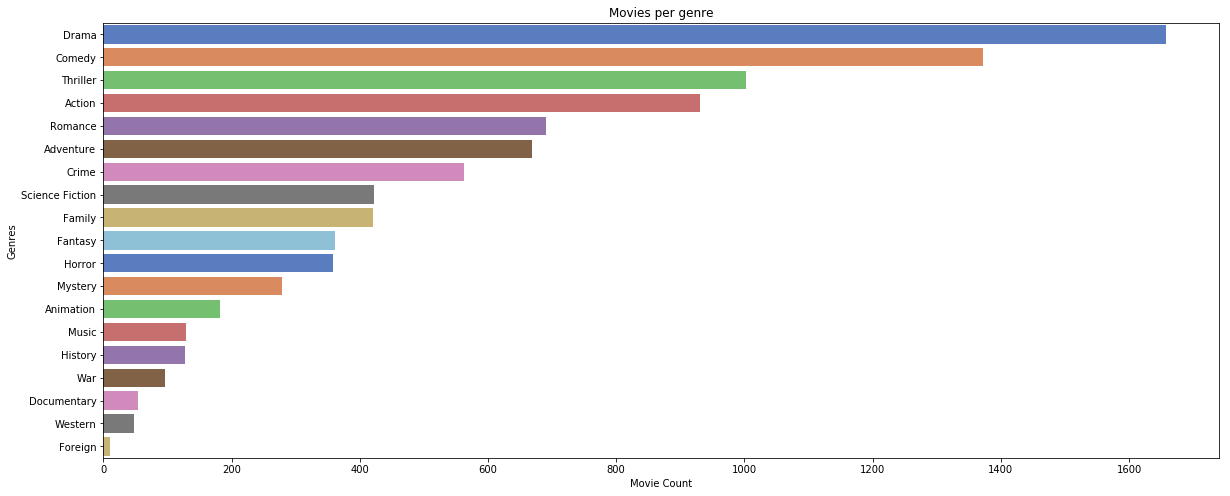

In [82]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(x="movie_title", y=genre.index, data=genre,dodge=False, palette='muted');
ax.set(xlabel='Movie Count', ylabel='Genres',title='Movies per genre')
plt.show()

## Analysis Questions

* Can we can predict a film’s genre based on its budget or other factors?
* Does social media have an impact on movie success? Do more social media likes lead to more profit generated?
* Looking at the patterns of budget spend over time - is there a noticeable increase or decrease. If so why?
* Predicting budget spend based on the genre of the movie
* Does the time of year a movie is released impact profit?
* Does a director’s IMDB score have any impact on popularity or profit ?
* Overall do economic impacts lead to a decrease in film uniqueness and originality?


# Prediciting a Film's Genre 

## K Nearest Neighbours Model

In [62]:
train, test = train_test_split(clean_string, test_size=0.2, random_state=22)
print(test.shape)
print(train.shape)

(1930, 23)
(7719, 23)


In [63]:
#Create X and Y train/test data
x_train = train[['budget_x', 'revenue']]
y_train = train['genres']

x_test = test[['budget_x','revenue']]
y_test = test['genres']

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (7719, 2)
y_train shape: (7719,)
x_test shape: (1930, 2)
y_test shape: (1930,)


In [64]:
#Initalise and Fit our model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [70]:
y_train_p = knn.predict(x_train)

print('Training set metrics')
print('Accuracy score: ', accuracy_score(y_train_p, y_train)) 
print('F1: ', f1_score(y_train_p, y_train, average='weighted')) 

Training set metrics
Accuracy score:  0.4093794532970592
F1:  0.4127599389667798


In [72]:
y_test_p = knn.predict(x_test)

print('Testing set metrics')
print('Accuracy score: ', accuracy_score(y_test_p, y_test)) 
print('F1: ', f1_score(y_test_p, y_test, average='weighted')) 

Testing set metrics
Accuracy score:  0.058031088082901555
F1:  0.06321767680789697


As we can see the model is performing poorly on the training set and extremly poorly on the test set. A reason for this may be the high number of variance in the provided values. Where budget and revenue can range anywhere from the tens of thousands up to millions of dollars.

## Cross Fold Validation Model

Fine tuning the parameters with CV looking at the accuracy score of different K values and CV folds.

In [46]:
neighbors = list(range(1,11))
cv_scores = []
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, x_test, y_test, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean()) #get mean for each fold
print(cv_scores)

[0.08418854150991122, 0.1068217133519486, 0.1065108461698886, 0.11677778158902034, 0.12294853931221836, 0.12814387685436576, 0.13060387810275947, 0.12701523732351333, 0.1296545075563627, 0.1390043128903034]


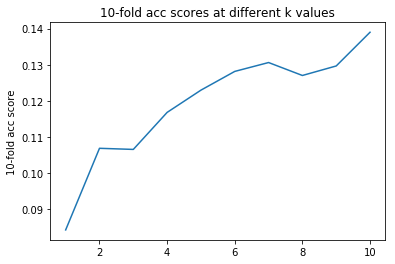

In [47]:
plt.plot(neighbors, cv_scores)
plt.ylabel("10-fold acc score")
plt.title("10-fold acc scores at different k values")
plt.show()

In [76]:
errors = [1-score for score in cv_scores] 
print(errors)

[0.9158114584900888, 0.8931782866480514, 0.8934891538301114, 0.8832222184109797, 0.8770514606877816, 0.8718561231456342, 0.8693961218972406, 0.8729847626764866, 0.8703454924436373, 0.8609956871096967]


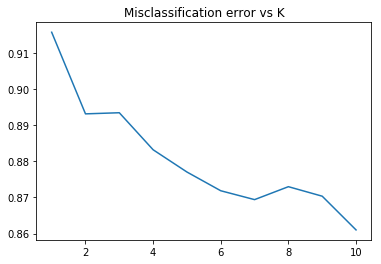

In [79]:
plt.plot(neighbors, errors)
plt.title("Misclassification error vs K")
plt.show()

The accuracy improves after 10 cv-folds however the model is still unable to adequately predict the genre. As we can see in the second plot, the misclassification error is very high, only dropping to 0.86 after 10 cv-folds.

#### Gaussian Naive Bayes

In [48]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB(priors=None)

In [49]:
y_train_pred = gnb.predict(x_train)
print('Accuracy score on training set: ', accuracy_score(y_train_pred, y_train)) 

Accuracy score on training set:  0.1642699831584402


In [50]:
y_test_pred = gnb.predict(x_test)
print('Accuracy score on testing set: ', accuracy_score(y_test, y_test_pred))

Accuracy score on testing set:  0.16062176165803108


In terms of overfitting Gaussian Navie Bayes is performing better than KNN, but still the model is predicitng very poorly.

#### Logistic Regression

In [51]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression()
lrmodel.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
y_train_pred = lrmodel.predict(x_train)

print('Training set metrics')
print('Accuracy score: ', accuracy_score(y_train_pred, y_train)) 
print('F1: ', f1_score(y_train_pred, y_train, average='weighted')) 

Training set metrics
Accuracy score:  0.11776136805285659
F1:  0.177742764954139


In [75]:
y_test_pred = lrmodel.predict(x_test)

print('Testing set metrics')
print('Accuracy score: ', accuracy_score(y_test_pred, y_test)) 
print('F1: ', f1_score(y_test_pred, y_test, average='weighted')) 

Testing set metrics
Accuracy score:  0.12538860103626942
F1:  0.1920031040500931


#### MLP Classifier

In [53]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=0)
mlp.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [54]:
mlpy_train_pred = mlp.predict(x_train)
mlpy_test_pred = mlp.predict(x_test)
print("train acc: ", accuracy_score(y_train, mlpy_train_pred))
print("test acc: ", accuracy_score(y_test,mlpy_test_pred))

train acc:  0.09172172561212592
test acc:  0.0922279792746114


MLP is not an effective predictor for genre for either of the implementations of train or test splits of data. 

Overall it is quite difficult to predict genre based on budget, revenue or gross variables.

# IMDB Score vs Gross

Is there a relationship between a movie's IMDB score and it's gross box office earnings?


## Decision Tree Regressor

In [55]:
#Converting 
clean_dummy['revenue'] = clean_dummy['revenue'].astype(int)

In [56]:
clean_dummy['gross'] = clean_dummy['gross'].astype(int)

In [57]:
train, test = train_test_split(clean_dummy, test_size=0.2, random_state=22)
print(test.shape)
print(train.shape)

(737, 42)
(2946, 42)


In [58]:
#Create X and Y train/test data
x_train = train[['gross', 'revenue']]
y_train = train['imdb_score']

x_test = test[['gross', 'revenue']]
y_test = test['imdb_score']

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2946, 2)
y_train shape: (2946,)
x_test shape: (737, 2)
y_test shape: (737,)


In [59]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

In [60]:
tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')